## Biomass statistics per production level

Data from [Fiskeridirektoratet](https://www.fiskeridir.no/Akvakultur/Tall-og-analyse/Biomassestatistikk/Biomassestatistikk-etter-produksjonsomraade)

### 1. Importing data

In [28]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from helpers.dicts import traffic_light
import seaborn as sns
import matplotlib.dates as mdates
import scipy as sp
from sklearn.linear_model import LinearRegression
pd.set_option('display.float_format', '{:.6f}'.format)

In [40]:
with open("input/biomasse.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data["Data"])

### 2. Cleaning data

* Standardization: Round "BIOMASSE_KG" to integer
* Merge: "TRAFFIC_LIGHTS" based on helpers/dicts.py
* Define "DATO" as a datetime
* Sum "UTSETTSÅR"
* Remove 2024
* Remove rainbow trout

In [41]:
df["BIOMASSE_KG"] = df["BIOMASSE_KG"].round().astype(int)
df["TRAFFIC_LIGHT"] = df["PO_KODE"].map(lambda x: traffic_light.get(x, {}).get("light"))
df["DATO"] = pd.to_datetime(df["ÅR"].astype(str) + "-" + df["MÅNED_KODE"].astype(str))
clean_df = df.groupby(["DATO", "PO_KODE", "PO_NAVN", "ARTSID", "TRAFFIC_LIGHT"]).agg({"BEHFISK_STK": "sum", "BIOMASSE_KG": "sum"}).reset_index()
clean_df = clean_df[(clean_df["DATO"].dt.year != 2024) & (clean_df["DATO"].dt.year != 2017)]
clean_df = clean_df[clean_df["ARTSID"] == "LAKS"]
#clean_df.to_csv("fisk_cleaned_data.csv")
clean_df

,DATO,PO_KODE,PO_NAVN,ARTSID,TRAFFIC_LIGHT,BEHFISK_STK,BIOMASSE_KG
54,2018-01-01,01,Svenskegrensen til Jæren,LAKS,green,6286393,7593363
55,2018-01-01,02,Ryfylket,LAKS,yellow,18591636,32775048
56,2018-01-01,03,Karmøy til Sotra,LAKS,red,44311636,97239721
58,2018-01-01,04,Nordhordland til Stadt,LAKS,red,37793696,73985062
60,2018-01-01,05,Stadt til Hustadvika,LAKS,yellow,13361104,30137021
...,...,...,...,...,...,...,...
1309,2023-12-01,09,Vestfjorden og Vesterålen,LAKS,green,52432656,91757708
1310,2023-12-01,10,Andøya til Senja,LAKS,green,41218437,75570638
1311,2023-12-01,11,Kvaløy til Loppa,LAKS,green,27181137,39321968
1312,2023-12-01,12,Vest-Finnmark,LAKS,green,48092209,84602456


### 3. Functions

* montly_laks: Takes the argument "red", "yellow" or "green" and returns a dataframe with the locations that matches the color. 
* pval: Computes the pvalue and slope for each location area and return a dataframe.
* dato_formatter: Calculates the unix timestamp back to readable date format.

In [ ]:
def monthly_laks(df, color):
    laks_df = df[(df["TRAFFIC_LIGHT"] == color) & (df['ARTSID'] == "LAKS")].copy()
    laks_df["DATO"] = pd.to_datetime(laks_df["DATO"])
    return laks_df

def pval(data):
    pval_rows = []
    for name in data["PO_NAVN"].unique():
        data_temp = data.query("PO_NAVN==@name")
        r, p = sp.stats.pearsonr(data_temp["DATO"], data_temp["BIOMASSE_KG"])
        pval_rows.append({"name": name, "pvalue": p, "slope": r})
    df_pvalue = pd.DataFrame(pval_rows)
    return df_pvalue

def dato_formatter():
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()
    return None

### 4. Processing data

##### 4.1 Histogram of biomass

In [ ]:
plt.figure(figsize=(8, 4))
clean_df["BIOMASSE_KG"].plot.hist(bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of biomass (kg)", fontsize=15)
plt.xlabel("Biomass in kg", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()

##### 4.2 Statistical numbers

In [ ]:
green = monthly_laks(clean_df, "green")["BIOMASSE_KG"].describe().round().astype(int)
yellow = monthly_laks(clean_df, "yellow")["BIOMASSE_KG"].describe().round().astype(int)
red = monthly_laks(clean_df, "red")["BIOMASSE_KG"].describe().round().astype(int)

describe = pd.concat([green, yellow, red], axis=1, join="inner")
describe.columns = ["Green", "Yellow", "Red"]
describe

##### 4.3 Line plot of red area

In [ ]:
laks_line = monthly_laks(clean_df, "red")
lineplot = sns.lineplot(data=laks_line, x='DATO', y='BIOMASSE_KG', hue='PO_NAVN', marker='o')
plt.xticks(rotation=45)
plt.title("Biomasse over time by location name")
plt.xlabel("Date")
plt.ylabel("Biomasse (kg)")
plt.legend(title="PO_NAVN")
plt.tight_layout()
plt.show()

### 5. Results

##### 5.1 Green areas

In [ ]:
laks_green = monthly_laks(clean_df, "green")
laks_green['DATO'] = mdates.date2num(laks_green['DATO'])
laks = sns.lmplot(data=laks_green, x="DATO", y="BIOMASSE_KG", hue="PO_NAVN", aspect=2)
dato_formatter()
plt.show()

##### 5.2 Yellow areas

In [ ]:
laks_yellow = monthly_laks(clean_df, "yellow")
laks_yellow['DATO'] = mdates.date2num(laks_yellow['DATO'])
laks = sns.lmplot(data=laks_yellow, x="DATO", y="BIOMASSE_KG", hue="PO_NAVN", aspect=2)
dato_formatter()
plt.show()

##### 5.3 Red areas

In [ ]:
laks_red = monthly_laks(clean_df, "red")
laks_red['DATO'] = mdates.date2num(laks_red['DATO'])
laks = sns.lmplot(data=laks_red, x="DATO", y="BIOMASSE_KG", hue="PO_NAVN", aspect=2)
dato_formatter()
plt.show()

##### 5.4 P-values and slope values

In [ ]:
pvalue_green = pval(laks_green).round(6)
pvalue_yellow = pval(laks_yellow).round(6)
pvalue_red = pval(laks_red).round(6)
pvalue_green["color"] = "green"
pvalue_yellow["color"] = "yellow"
pvalue_red["color"] = "red"
pvalues = pd.concat([pvalue_green, pvalue_yellow, pvalue_red]).reset_index(drop=True)
pvalues 

### 6. Further analysis

In [53]:
def linear_regression(df):
    # Slå sammen tallene for hver måned og gjøre klar for regresjonsananlyse ved å legge til en kolonne med tid (dager)
    monthly_biomass = df.groupby('YearMonth')['BIOMASSE_KG'].sum().reset_index()
    monthly_biomass['YearMonth'] = monthly_biomass['YearMonth'].astype(str)
    monthly_biomass['YearMonth'] = pd.to_datetime(monthly_biomass['YearMonth'])
    monthly_biomass['TimeIndex'] = (monthly_biomass['YearMonth'] - monthly_biomass['YearMonth'].min()).dt.days

    # Lag modellen, kjør den og lagre en egen kolonne med resultatet
    X = monthly_biomass[['TimeIndex']]
    y = monthly_biomass['BIOMASSE_KG']
    model = LinearRegression()
    model.fit(X, y)
    monthly_biomass['Predicted_Biomass'] = model.predict(X)

    # Vis graf
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_biomass['YearMonth'], monthly_biomass['BIOMASSE_KG'], label='Actual Biomass', marker='o')
    plt.plot(monthly_biomass['YearMonth'], monthly_biomass['Predicted_Biomass'], label='Predicted Biomass', linestyle='--')
    plt.xlabel('Month')
    plt.ylabel('Total Biomass (kg)')
    plt.title('Regression Analysis of Monthly Biomass')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Koeffisienten og interception
    print(model.coef_, model.intercept_)
        
# Gjøre om til datoformat
clean_df['DATO'] = pd.to_datetime(clean_df['DATO'])
clean_df['YearMonth'] = clean_df['DATO'].dt.to_period('M')

total = clean_df
red = clean_df[clean_df["TRAFFIC_LIGHT"] == "red"]
yellow = clean_df[clean_df["TRAFFIC_LIGHT"] == "yellow"]
green = clean_df[clean_df["TRAFFIC_LIGHT"] == "green"]
area = clean_df[clean_df["PO_KODE"] == "01"]

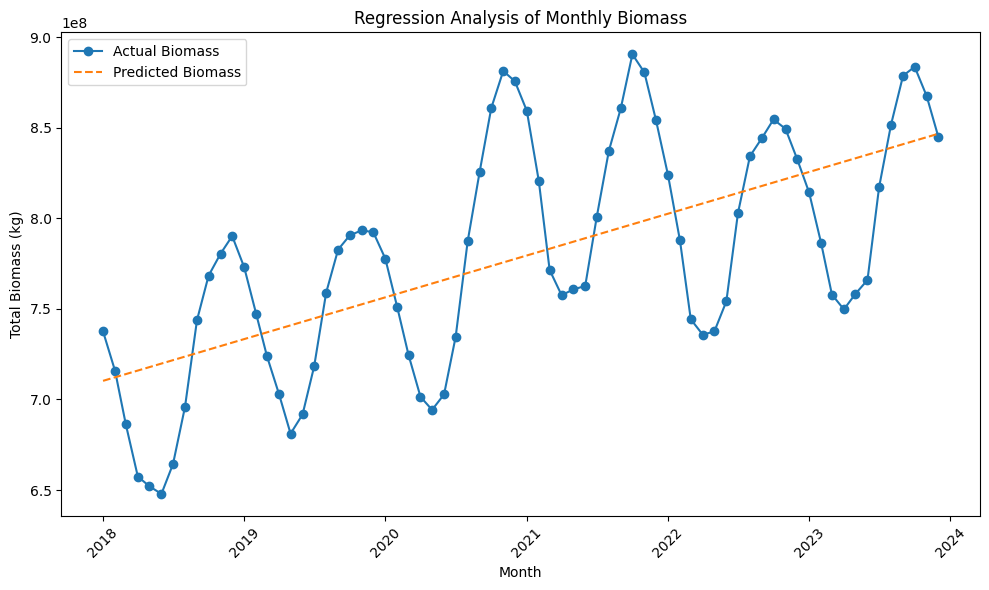

[63127.62541902] 710251110.8705293


In [57]:
linear_regression(total)

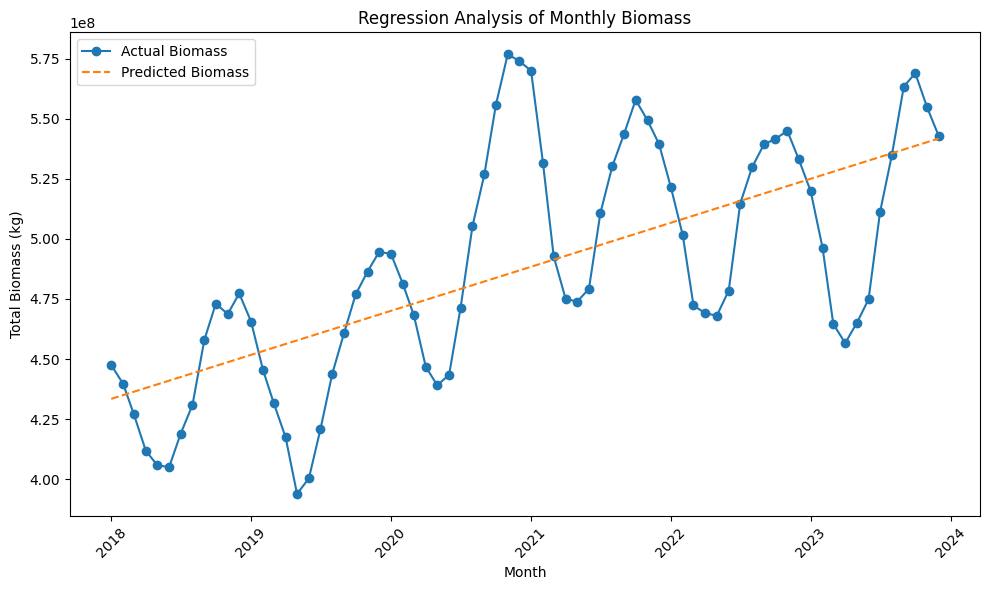

[50154.69895055] 433446701.0524764


In [54]:
linear_regression(green)

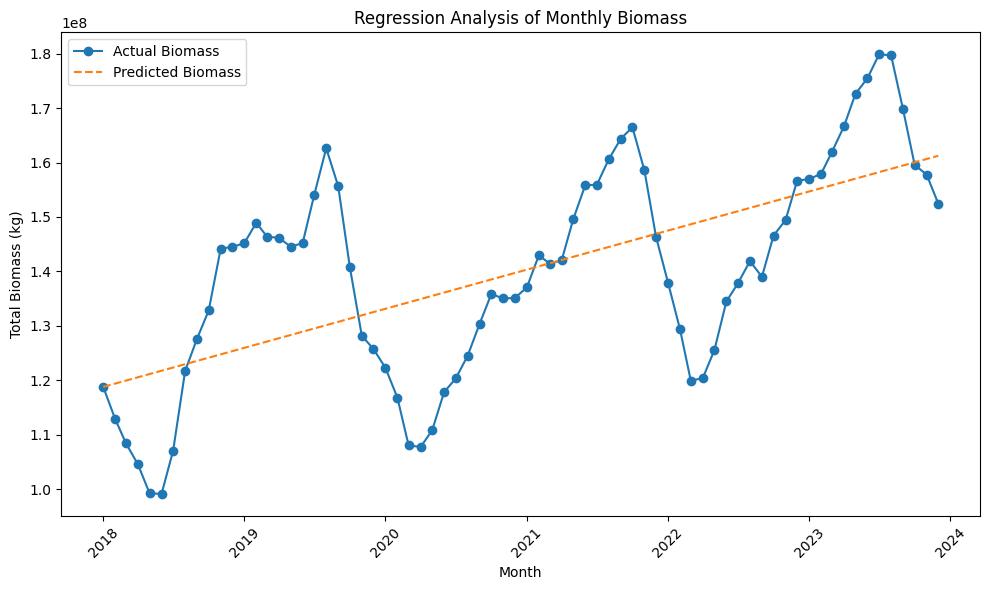

[19652.99046977] 118784586.51142596


In [55]:
linear_regression(yellow)

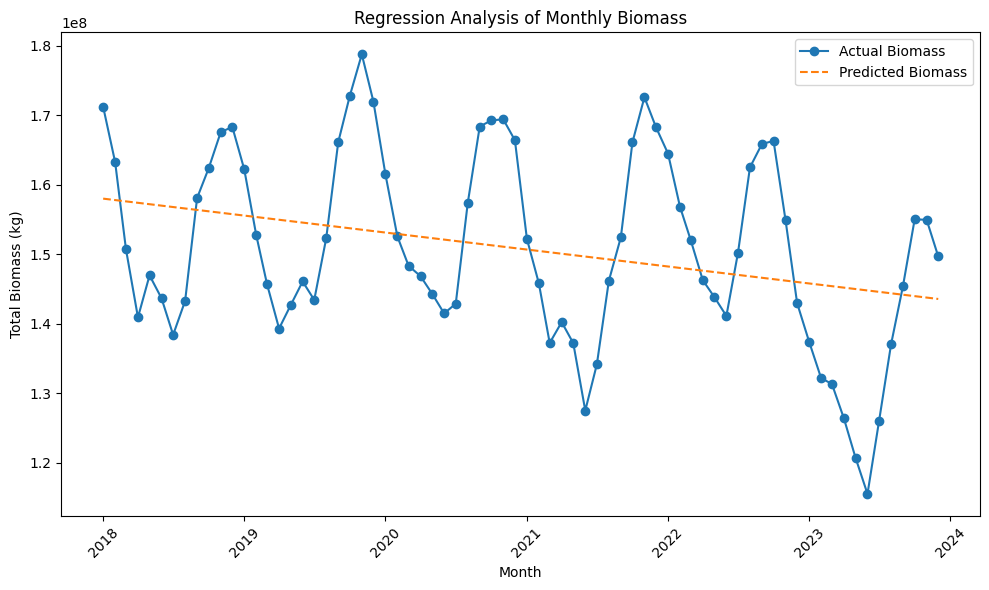

[-6680.0640013] 158019823.3066269


In [56]:
linear_regression(red)